# VideoMAE 2D Training Notebook

This notebook trains a 2D MAE model using an HDF5 dataset:
- Load an HDF5 file from a path
- Split trials into train/val using `split_data`
- Create datasets via `create_dataset('vsd_mae', ...)` and DataLoaders
- Build a 2D MAE (ResNet18 backbone + lightweight decoder)
- Train and log metrics to TensorBoard



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!rm -rf VSD_foundation_model
!git clone --branch None_to_null https://github.com/ossnat/VSD_foundation_model.git
!ln -s '/content/drive/My Drive/VSD_FM/Data' '/content'

Cloning into 'VSD_foundation_model'...
remote: Enumerating objects: 581, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 581 (delta 4), reused 0 (delta 0), pack-reused 544 (from 1)
Receiving objects: 100% (581/581), 5.51 MiB | 13.63 MiB/s, done.
Resolving deltas: 100% (345/345), done.
ln: failed to create symbolic link '/content/Data': File exists


In [17]:
# Imports and configuration
import os
import sys
import yaml
import torch
from torch.utils.data import DataLoader, Subset
from pathlib import Path

project_root = Path('VSD_foundation_model')
sys.path.insert(0, str(project_root))

from src.data import load_dataset, create_dataset, VsdVideoDataset
from src.models.backbone.mae_backbone_2d import MAEResNet18Backbone
from src.models.heads.mae_decoder_2d import MAEDecoder2D
from src.models.systems.mae_system import MAESystem
from src.utils.logger import TBLogger, set_seed
from src.training.trainer import Trainer

# Load config
config_path = "VSD_foundation_model/configs/default.yaml"
with open(config_path, 'r') as f:
  cfg = yaml.safe_load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


# # --- User config ---
# HDF5_PATH = r"G:\My Drive\HDF5_DATA_AFTER_PREPROCESSING2\vsd_video_data.hdf5"
# LOG_DIR = "logs"
# CKPT_DIR = "checkpoints"
# SEED = 42

# # Data params
# CLIP_LENGTH = 1           # 1 -> 2D (single frame); >1 creates clips but MAE2D squeezes T=1
# BATCH_SIZE = 8
# NUM_WORKERS = 2
# SPLIT_RATIO = 0.8

# # Masking params for dataset
# MASK_RATIO = 0.75
# PATCH_SIZE = (1, 16, 16)  # (T, H, W); T=1 for 2D

# # Training params
# EPOCHS = 5
# LR = 1e-4
# WEIGHT_DECAY = 0.05

# # Setup
# os.makedirs(LOG_DIR, exist_ok=True)
# os.makedirs(CKPT_DIR, exist_ok=True)
# set_seed(SEED)
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {DEVICE}")

In [3]:
batch_size=32
train_loader = load_dataset(cfg, split="train", batch_size=batch_size, num_workers=0, shuffle=False)

Loading split CSV from Data/FoundationData/ProcessedData/splits/split_v1_seed17_strat_monkey.csv...
Successfully read CSV with standard settings
Found CSV columns (10 total): ['trial_global_id', 'monkey', 'date', 'condition', 'source_file', 'target_file', 'trial_index_in_condition', 'shape', 'trial_dataset', 'split']
CSV shape: (5706, 10) (rows x columns)
Required columns found: ['target_file', 'trial_dataset', 'shape', 'split'] out of ['target_file', 'trial_dataset', 'shape', 'split']
Sample first row (showing required columns):
  target_file: Data/FoundationData/ProcessedData/boromir/session_220622d_condsAN.h5
  trial_dataset: trial_000008
  shape: (10000, 256)
  split: train
Found 3994 trials for split 'train'
Loading stats from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.json...
Loading mean and std from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.h5...
Loaded normalization stats from H5 file:
  Mean range: [0.99

In [4]:
val_loader = load_dataset(cfg, split="val", batch_size=batch_size, num_workers=0, shuffle=False)

Loading split CSV from Data/FoundationData/ProcessedData/splits/split_v1_seed17_strat_monkey.csv...
Successfully read CSV with standard settings
Found CSV columns (10 total): ['trial_global_id', 'monkey', 'date', 'condition', 'source_file', 'target_file', 'trial_index_in_condition', 'shape', 'trial_dataset', 'split']
CSV shape: (5706, 10) (rows x columns)
Required columns found: ['target_file', 'trial_dataset', 'shape', 'split'] out of ['target_file', 'trial_dataset', 'shape', 'split']
Sample first row (showing required columns):
  target_file: Data/FoundationData/ProcessedData/boromir/session_220622d_condsAN.h5
  trial_dataset: trial_000008
  shape: (10000, 256)
  split: train
Found 856 trials for split 'val'
Loading stats from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.json...
Loading mean and std from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.h5...
Loaded normalization stats from H5 file:
  Mean range: [0.9996,

In [5]:
test_loader = load_dataset(cfg, split="test", batch_size=batch_size, num_workers=0, shuffle=False)

Loading split CSV from Data/FoundationData/ProcessedData/splits/split_v1_seed17_strat_monkey.csv...
Successfully read CSV with standard settings
Found CSV columns (10 total): ['trial_global_id', 'monkey', 'date', 'condition', 'source_file', 'target_file', 'trial_index_in_condition', 'shape', 'trial_dataset', 'split']
CSV shape: (5706, 10) (rows x columns)
Required columns found: ['target_file', 'trial_dataset', 'shape', 'split'] out of ['target_file', 'trial_dataset', 'shape', 'split']
Sample first row (showing required columns):
  target_file: Data/FoundationData/ProcessedData/boromir/session_220622d_condsAN.h5
  trial_dataset: trial_000008
  shape: (10000, 256)
  split: train
Found 856 trials for split 'test'
Loading stats from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.json...
Loading mean and std from Data/FoundationData/ProcessedData/splits/baseline_stats_v1_seed17_strat_monkey.h5...
Loaded normalization stats from H5 file:
  Mean range: [0.9996

In [12]:
# from src.models.backbone.mae_backbone_3d import MAER3D18Backbone
# from src.models.heads.mae_decoder_3d import MAEDecoder3D

# Build MAE 2D model and optimizer
encoder = MAEResNet18Backbone(pretrained=False, in_channels=1)
decoder = MAEDecoder2D(in_channels=encoder.feature_dim, out_channels=1, hidden_dim=256)

# config = {
#     "training": {"lr": LR, "weight_decay": WEIGHT_DECAY},
#     "loss": {"normalize": True},
# }

# Load config
model_config_path = "VSD_foundation_model/configs/model_configs/mae_2d_config.yaml"
with open(config_path, 'r') as f:
  model_cfg = yaml.safe_load(f)


model = MAESystem(encoder=encoder, decoder=decoder, config=model_cfg).to(device)
optimizer = model.get_optimizer()

print(model.__class__.__name__, "built.")


MAESystem built.


In [18]:
# Train using generic Trainer (supports MAE 2D/3D and DINO)

# trainer_cfg = {
#     "epochs": EPOCHS,
#     "lr": LR,
#     "weight_decay": WEIGHT_DECAY,
#     "log_dir": LOG_DIR,
#     "ckpt_dir": CKPT_DIR,
# }


logger = TBLogger(log_dir="logs")
trainer = Trainer(model=model, logger=logger, cfg=model_cfg, device=device)
trainer.fit(train_loader, val_loader)


Epoch 1/3:   0%|          | 0/15103 [00:03<?, ?it/s]


IndexError: too many indices for tensor of dimension 5

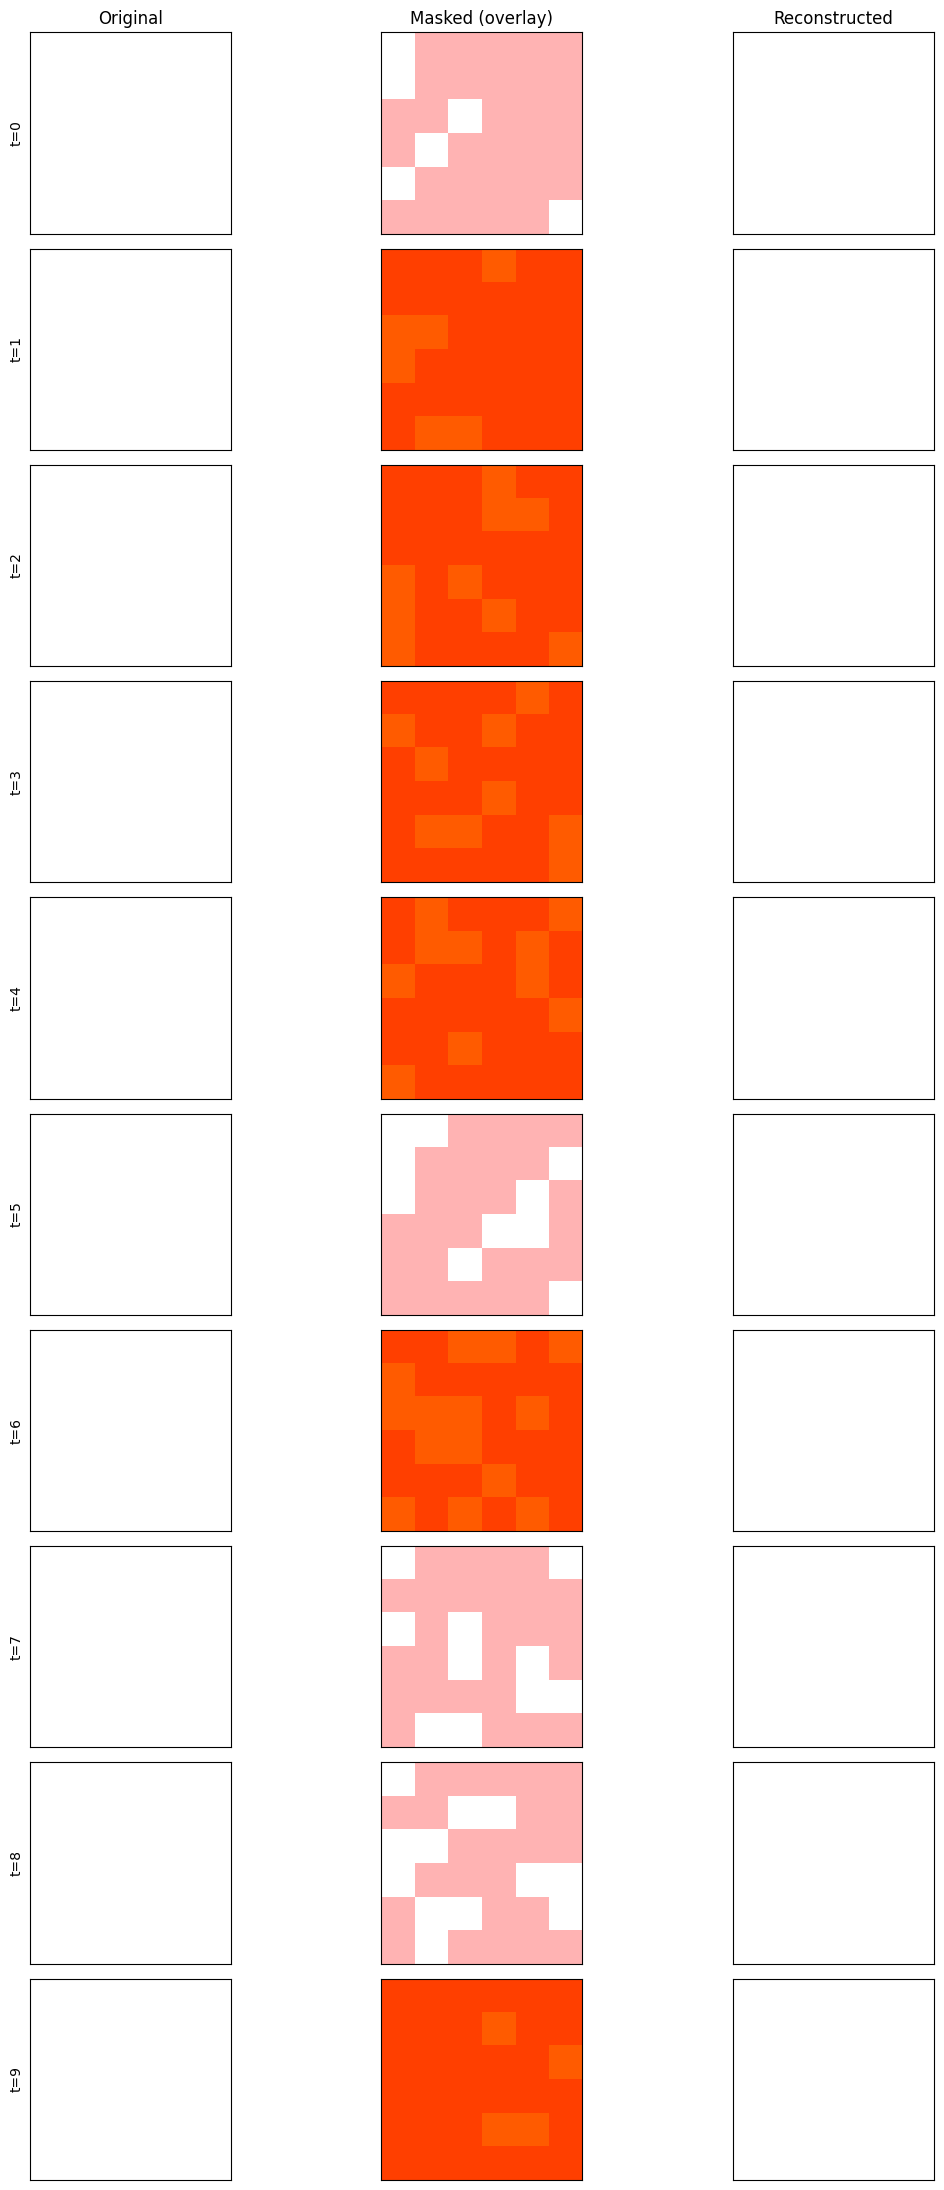

✅ Sequence visualization complete (rows=time, cols=[orig, masked+overlay, recon]).


In [ ]:
# Sequence visualization: plot Original, Masked(+overlay), Reconstructed vertically over time
import numpy as np
import torch.nn.functional as F

# Define a minimal version
def get_reconstruction(model, batch):
    model.eval()
    with torch.no_grad():
        video_masked = batch["video_masked"]
        video_target = batch["video_target"]
        mask = batch["mask"]
        is_2d = False
        if len(video_target.shape) == 5 and video_target.shape[2] == 1:
            is_2d = True
            video_masked = video_masked.squeeze(2)
            video_target = video_target.squeeze(2)
            if len(mask.shape) == 5:
                mask = mask.squeeze(2)
            if len(mask.shape) == 4 and mask.shape[1] == 1:
                H, W = video_target.shape[2], video_target.shape[3]
                mask = F.interpolate(mask, size=(H, W), mode='nearest')
        features = model.encoder(video_masked)
        if is_2d or len(video_target.shape) == 4:
            target_size = (video_target.shape[2], video_target.shape[3])
            reconstruction = model.decoder(features, target_size=target_size)
        else:
            target_size = (video_target.shape[2], video_target.shape[3], video_target.shape[4])
            reconstruction = model.decoder(features, target_size=target_size)
            if len(mask.shape) == 5 and mask.shape[1] == 1:
                T, H, W = video_target.shape[2], video_target.shape[3], video_target.shape[4]
                mask = F.interpolate(mask, size=(T, H, W), mode='nearest')
        return reconstruction, mask, video_target, video_masked

# Fetch a validation batch and reconstruct
model.eval()
val_sample = next(iter(val_loader))
val_sample = {k: v.to(DEVICE) for k, v in val_sample.items()}
reconstruction, mask, original, masked = get_reconstruction(model, val_sample)

# Select first item in batch
b = 0
vmin, vmax = -0.003, 0.003

# Determine dimensionality
# 2D: (C,H,W); 3D: (C,T,H,W)
if original.ndim == 4:  # (B,C,H,W)
    # Single frame (2D)
    T = 1
    orig_frames = original[b, 0][None]      # (1,H,W)
    masked_frames = masked[b, 0][None]
    mask_frames = mask[b, 0]
    if mask_frames.ndim == 2:
        mask_frames = mask_frames[None]     # (1,H,W)
    recon_frames = reconstruction[b, 0][None]
else:
    # Video (3D time): (B,C,T,H,W)
    T = original.shape[2]
    orig_frames = original[b, 0].cpu()          # (T,H,W)
    masked_frames = masked[b, 0].cpu()          # (T,H,W)
    recon_frames = reconstruction[b, 0].cpu()   # (T,H,W)
    mask_frames = mask[b, 0].cpu()              # (T,H,W) after model fix

# Limit number of frames for display
max_rows = 12
rows = min(T, max_rows)
fig, axes = plt.subplots(rows, 3, figsize=(12, 2.2*rows))
if rows == 1:
    axes = np.array([axes])

for t in range(rows):
    # Original
    axes[t, 0].imshow(orig_frames[t].cpu().numpy() if torch.is_tensor(orig_frames[t]) else orig_frames[t], cmap='hot', vmin=vmin, vmax=vmax)
    axes[t, 0].set_ylabel(f"t={t}")
    axes[t, 0].set_xticks([]); axes[t, 0].set_yticks([])
    if t == 0:
        axes[t, 0].set_title('Original')

    # Masked + overlay
    im = axes[t, 1].imshow(masked_frames[t].cpu().numpy() if torch.is_tensor(masked_frames[t]) else masked_frames[t], cmap='hot', vmin=vmin, vmax=vmax)
    m = mask_frames[t].cpu().numpy() if torch.is_tensor(mask_frames[t]) else mask_frames[t]
    overlay = np.zeros((m.shape[0], m.shape[1], 4), dtype=np.float32)
    overlay[..., 0] = 1.0
    overlay[..., 3] = 0.3 * (1.0 - m)  # red where masked
    axes[t, 1].imshow(overlay)
    axes[t, 1].set_xticks([]); axes[t, 1].set_yticks([])
    if t == 0:
        axes[t, 1].set_title('Masked (overlay)')

    # Reconstructed
    axes[t, 2].imshow(recon_frames[t].cpu().numpy() if torch.is_tensor(recon_frames[t]) else recon_frames[t], cmap='hot', vmin=vmin, vmax=vmax)
    axes[t, 2].set_xticks([]); axes[t, 2].set_yticks([])
    if t == 0:
        axes[t, 2].set_title('Reconstructed')

plt.tight_layout()
plt.show()
print("✅ Sequence visualization complete (rows=time, cols=[orig, masked+overlay, recon]).")
